# Display Trace

## Packages

In [1]:
import os

import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from tqdm.auto import tqdm

In [51]:
def scale(v, s=1):
    """Scale the vector of y \in R3,
    s is the  scaler,
    It computes the normalized vector of y is s = 1 as default.
    """
    return s * np.array(v) / np.linalg.norm(v)


def rotate(r, n, a):
    """Compute the rotated vector of r \in R3,
    n \in R3 is the rotate axis,
    a \in R is the radius.
    """
    d = np.cross(n, r)

    if all(d == 0):
        return r

    o = scale(scale(r, np.cos(a)) + scale(d, np.sin(a)))
    return o


class Point(object):
    """A point has its position and x-, y- and z- normalized coordinates"""

    def __init__(self, p=[0, 0, 0], nx=[1, 0, 0], ny=[0, 1, 0], nz=[0, 0, 1]):
        """
        Initialize the point,
        - p: The origin of the point;
        - nx: The normed x axis;
        - ny: The normed y axis;
        - nz: The normed z axis.
        """
        self.p = np.array(p).astype(np.float32)
        self.nx = scale(nx)
        self.ny = scale(ny)
        self.nz = scale(nz)
        pass

    def translate(self, dp):
        """Translate the point by p \in R3"""
        self.p += dp
        pass

    def rotate(self, ax, ay, az):
        """The point rotates around its origin, by 3 axis at ax, ay and az radius"""
        # self.nx = rotate(self.nx, self.nx, ax)
        self.ny = rotate(self.ny, self.nx, ax)
        self.nz = rotate(self.nz, self.nx, ax)

        self.nx = rotate(self.nx, self.ny, ay)
        # self.ny = rotate(self.ny, self.ny, ay)
        self.nz = rotate(self.nz, self.ny, ay)

        self.nx = rotate(self.nx, self.nz, az)
        self.ny = rotate(self.ny, self.nz, az)
        # self.nz = rotate(self.nz, self.nz, az)
        pass

    def snip(self):
        """Get a quick snip of the point on the current state"""
        # The p changes in-place, so use hard copy here.
        return [self.p.copy(), self.nx, self.ny, self.nz]


class MotionTrace(object):
    """Trace the motion and record every step"""

    def __init__(self):
        """Initialize"""
        # Dynamic point
        self.point = Point()

        # The point walks step-by-step,
        # the trace records its path.
        self.trace = []
        self.num_steps = 0

        # Reset the speed and angle
        self.dax = 0
        self.day = 0
        self.daz = 0
        self.dp = np.array((0.0, 0, 0))

        # Place the first point
        self.forward()
        pass

    def forward(self, ap=(0, 0, 0), aax=0, aay=0, aaz=0):
        """
        Forward a step,
        - ap: The accelerate of translating the position;
        - aax, aay, aaz: The angular accelerate of rotation along the x-, y- and z- axis.
        """

        def rad(x):
            return x / 180 * np.pi

        self.dax += aax
        self.day += aay
        self.daz += aaz
        self.dp += ap

        self.point.translate(self.dp)
        self.point.rotate(rad(self.dax), rad(self.day), rad(self.daz))
        self.trace.append(self.point.snip())

        self.num_steps += 1
        pass

    def trace_origin(self):
        """
        Trace the origins along the motion,
        it will return a matrix \in R^{n x 3},
        - n refers the steps, it equals to the self.num_samples;
        - 3 refers the x-, y- and z- coordinates.
        """
        return np.array([e[0] for e in self.trace])
    
    def trace_finish(self, length=500):
        """
        Trace the finish along the motion,
        the input
        - length refers the length of the arm/leg.
        the length grows at the negative direction of the z-axis.
        
        It will return a matrix \in R^{n x 3},
        - n refers the steps, it equals to the self.num_samples;
        - 3 refers the x-, y- and z- coordinates;
        """
        return np.array([e[0] - e[3] * length for e in self.trace])
    

## Read Parameters

In [27]:
folder = os.path.join(
    os.environ["SYNC"], r"MotionData\data\2nd-Development", "parsedData"
)

event_name = {
    "0-SLW": 1,
    "1-MLW": 2,
    "2-FLW": 3,
    "3-RD": 4,
    "4-SD": 5,
    "5-sit": 6,
    "6-stand": 7,
    "7-RA": 8,
    "8-SA": 9,
}

event_table = [(a, b) for a, b in event_name.items()]
print(event_table)

# Read and mark the Signal
X3s = []
ys = []

for name, label in event_name.items():
    with open(os.path.join(folder, f"{name}.npy"), "rb") as f:
        mat = np.load(f)
    X3s.append(mat)
    ys.append(np.zeros(mat.shape[0]) + label)

X3 = np.concatenate(X3s)
y = np.concatenate(ys)

# Simple Report
X3.shape, y.shape

[('0-SLW', 1), ('1-MLW', 2), ('2-FLW', 3), ('3-RD', 4), ('4-SD', 5), ('5-sit', 6), ('6-stand', 7), ('7-RA', 8), ('8-SA', 9)]


((31625, 20, 6), (31625,))

## Take an Example

In [3]:
pd.DataFrame(X3[0])

,0,1,2,3,4,5
0,-0.46,-0.35,-1.46,-48.23,196.47,44.74
1,-0.47,-0.21,-1.49,-60.67,180.91,52.67
2,-0.46,-0.04,-1.51,-26.38,179.34,56.34
3,-0.36,0.06,-1.45,24.03,177.45,47.34
4,-0.12,-0.01,-1.32,49.87,171.94,39.17
5,0.13,-0.13,-1.26,63.96,161.90,28.58
6,0.28,-0.25,-1.28,67.75,144.61,23.74
7,0.29,-0.28,-1.28,61.36,112.47,21.50
8,0.31,-0.27,-1.23,49.75,78.09,19.36
9,0.29,-0.18,-1.19,36.56,49.82,18.97


## Compute the Trace

  0%|          | 0/21 [00:00<?, ?it/s]

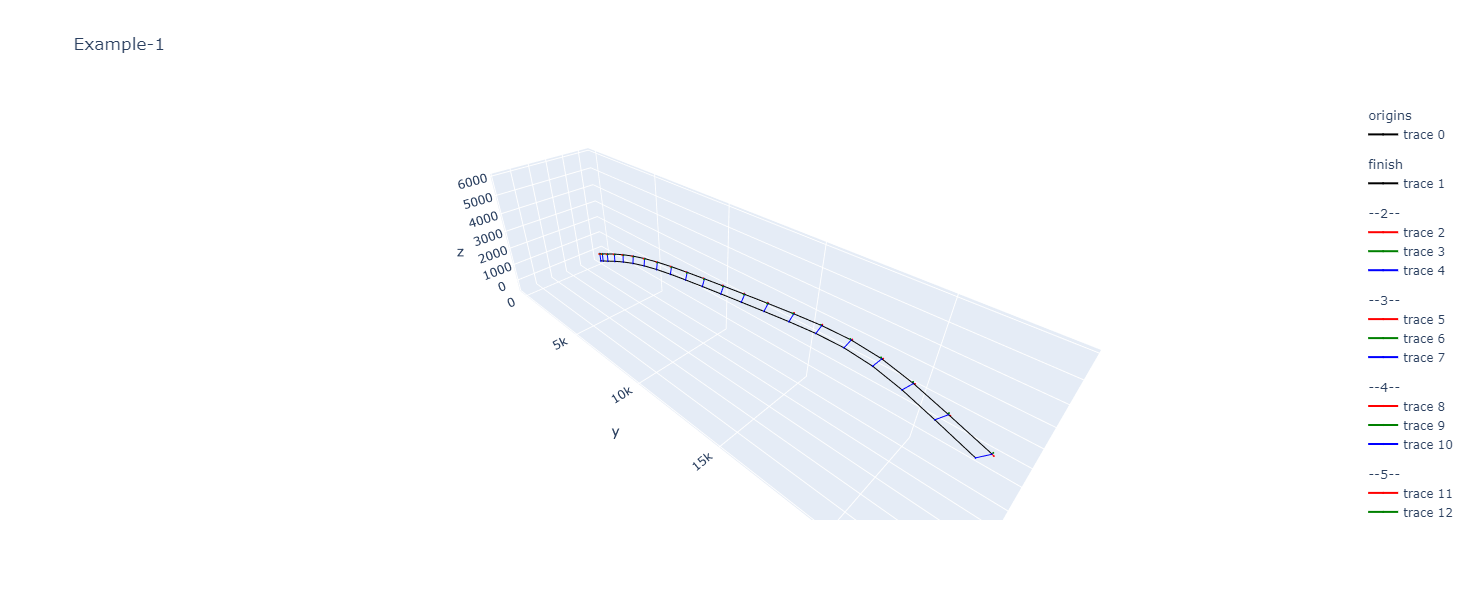

In [52]:
# -------------------------------------------------------------
# Build the Trace
mt = MotionTrace()

for d in X3[0]:
    mt.forward(ap=d[3:], aax=d[0], aay=d[1], aaz=d[2])

mt.trace

# -------------------------------------------------------------
# Draw
data = []

group_idx = 0

# Draw origin and finish
trace_origin = mt.trace_origin()
trace_finish = mt.trace_finish()
color = "black"

data.append(
    go.Scatter3d(
        x=trace_origin[:, 0],
        y=trace_origin[:, 1],
        z=trace_origin[:, 2],
        marker={"size": 1, "color": color},
        line={"color": color, "width": 2},
        legendgroup=group_idx,
        legendgrouptitle={"text": 'origins'},
    )
)
group_idx += 1

data.append(
    go.Scatter3d(
        x=trace_finish[:, 0],
        y=trace_finish[:, 1],
        z=trace_finish[:, 2],
        marker={"size": 1, "color": color},
        line={"color": color, "width": 2},
        legendgroup=group_idx,
        legendgrouptitle={"text": 'finish'},
    )
)
group_idx += 1

# Draw legs
for p in tqdm(mt.trace):
    origin = p[0]
    for axis, color, length in zip(p[1:], ["red", "green", "blue"], [50, 50, -500]):
        data.append(
            go.Scatter3d(
                x=[origin[0], origin[0] + axis[0] * length],
                y=[origin[1], origin[1] + axis[1] * length],
                z=[origin[2], origin[2] + axis[2] * length],
                marker={"size": 1, "color": color},
                line={"color": color, "width": 2},
                legendgroup=group_idx,
                legendgrouptitle={"text": f"--{group_idx}--"},
            )
        )
    group_idx += 1

fig = go.Figure(data=data)
fig.update_layout(
    title="Example-1",
    width=1000,
    height=600,
    scene=dict(aspectratio=dict(x=1, y=1, z=1), aspectmode="data"),
)
fig.show()